# Using SentenceTransformer/GPT to analyze sentiment

# 1. Sentence Transformer 

## Load data

In [ ]:
pip install torch 

In [ ]:
pip install transformers

In [1]:
import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import KFold

In [2]:
data = pd.read_csv("/Users/rufen/Documents/GitHub/LLM_Financial_Chatbot/all-data.csv",delimiter=',', encoding='latin-1', header=None)
data = data.rename(columns = lambda x : ['sentiment','sentence'][x])
data.head()

,sentiment,sentence
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [3]:
print('The shape of this data set is', data.shape)
print(data.info())
print(data.isnull().mean())

The shape of this data set is (4846, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  4846 non-null   object
 1   sentence   4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB
None
sentiment    0.0
sentence     0.0
dtype: float64


In [4]:
data['sentiment'].value_counts()

neutral     2879
positive    1363
negative     604
Name: sentiment, dtype: int64

#### I just didi EDA part in another notebook, so, here, skip this part

## Prepare data

### Clean data

In [5]:
# define functions 
from bs4 import BeautifulSoup

def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def stopwords_removal(words):
    list_stopwords = nltk.corpus.stopwords.words('english')
    return [word for word in words if word not in list_stopwords]

In [ ]:
pip install contractions

In [6]:
#  NLP data cleaning process
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import tqdm
import unicodedata
import contractions

from nltk.tokenize import word_tokenize

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    #case folding
    doc = doc.lower()
    #remove special characters\whitespaces
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()
    #tokenize
    doc = word_tokenize(doc)
    #filtering
    doc = stopwords_removal(doc)
    norm_docs.append(doc)
  
  norm_docs = [" ".join(word) for word in norm_docs]
  return norm_docs

[nltk_data] Downloading package punkt to /Users/rufen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/rufen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
%%time
data.sentence = pre_process_corpus(data.sentence)

 20%|███████▋                              | 973/4846 [00:00<00:01, 2128.65it/s]/var/folders/mq/6chk45p9099bllbg1_nny_bc0000gn/T/ipykernel_96044/1686883243.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
100%|█████████████████████████████████████| 4846/4846 [00:01<00:00, 3450.33it/s]

CPU times: user 1.24 s, sys: 155 ms, total: 1.39 s
Wall time: 1.43 s


In [8]:
data.head()

,sentiment,sentence
0,neutral,according gran company plans move production r...
1,neutral,technopolis plans develop stages area less 100...
2,negative,international electronic industry company elco...
3,positive,new production plant company would increase ca...
4,positive,according company updated strategy years 20092...


### Imbalance handling

In [20]:
df1=data[data['sentiment']=='positive']
df2=data[data['sentiment']=='negative']

In [21]:
df_negative_upsampled = resample(df2, replace = True,
                                n_samples = df1.shape[0],
                                random_state = 123)

df_balanced = pd.concat([df1,df_negative_upsampled])

print("before upsampling, the number of negative sentence is", df2.shape[0])
print("before upsampling, the number of positive sentence is", df1.shape[0])
print("after upsampling:\n", df_balanced.sentiment.value_counts(),sep="")

before upsampling, the number of negative sentence is 604
before upsampling, the number of positive sentence is 1363
after upsampling:
positive    1363
negative    1363
Name: sentiment, dtype: int64


In [27]:
df_balanced['sentiment'] = df_balanced['sentiment'].apply(lambda x : 1 if x == 'positive' else 0)
df_balanced['sentiment'].value_counts()

1    1363
0    1363
Name: sentiment, dtype: int64

### Split data

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced.sentence, df_balanced.sentiment, test_size=0.1, random_state=42)
X_train.shape , X_test.shape, y_train.shape, y_test.shape

((2453,), (273,), (2453,), (273,))

## Modeling

In [14]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'  ## for faster computation
# tokenizer.add_tokens(['[TITLE]: ','[SUMMARY]: '])
# model.resize_token_embeddings(len(tokenizer))
model.to(device)


def get_embeddings(text):
    ## encode the input text using a pre-trained tokenize
    input_ids = tokenizer.encode(text,
                                 add_special_tokens=True,
                                 truncation=True,
                                 return_tensors='pt').to(device)
    
    with torch.inference_mode():
        # get the output of the last hidden states
        last_hidden_state = model(input_ids)[0].to(device)
        # calculate the embeddings for the input text by taking the mean of the lasthidden state across all tokens in the input sequence.
        # across all tokens int he input sequence
        embeddings = torch.mean(last_hidden_state,dim=1).squeeze().to(device)
        
    return embeddings.cpu().numpy() ## move the embedding back to cpu

In [54]:
## tokenize the dataset
train_embeddings = np.array([get_embeddings(text) for text in X_train])

X = train_embeddings
y = y_train  # Assuming y_train contains sentiment labels directly

In [ ]:
# # Apply PCA to reduce the dimensionality of embedded sentences
# from sklearn.decomposition import PCA

# pca = PCA(n_components=100)  # Adjust the number of components as needed
# X_train_pca = pca.fit_transform(X)

### Parameter tuning
* n_estimators: The number of boosting rounds.
* learning_rate: Step size shrinkage used in update to prevent overfitting.
* max_depth: Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.
* subsample: Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost randomly collects half of the data instances to grow trees and this prevents overfitting.
* colsample_bytree: The subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.

The process involves splitting the training data into k distinct subsets (or folds), then training the model k times, each time using a different fold as the validation set and the remaining k−1 folds as the training set.

In [44]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold
from xgboost import XGBClassifier

# Split the data into k folds
k = 7
kf = KFold(n_splits=k, shuffle=True, random_state=42)

accuracy_scores = []
f1_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print(f"Fold {fold + 1}/{k}")
    
    # Convert X to a pandas DataFrame if it's a numpy array
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)
        
    # Splitting data for this fold
    fold_X_train, fold_X_val = X.iloc[train_index], X.iloc[val_index]
    fold_y_train, fold_y_val = y.iloc[train_index], y.iloc[val_index]

    # Initialize and train XGBoost classifier instead of regressor
    xgb = XGBClassifier(n_estimators=495, 
                        max_depth=4, 
                        learning_rate=0.0419905195591556,
                        subsample=0.8, 
                        reg_lambda=0.25, 
                        random_state=42)
    xgb.fit(fold_X_train, fold_y_train)
    
    # Make predictions and evaluate
    fold_preds = xgb.predict(fold_X_val)
    fold_accuracy = accuracy_score(fold_y_val, fold_preds)
    fold_f1 = f1_score(fold_y_val, fold_preds)
    
    accuracy_scores.append(fold_accuracy)
    f1_scores.append(fold_f1)
    
    print(f"Accuracy for Fold {fold + 1}: {fold_accuracy:.4f}")
    print(f"F1 Score for Fold {fold + 1}: {fold_f1:.4f}")

# Calculate and print the average metrics across all folds
average_accuracy = sum(accuracy_scores) / len(accuracy_scores)
average_f1 = sum(f1_scores) / len(f1_scores)
print(f"Average Accuracy across all folds: {average_accuracy:.4f}")
print(f"Average F1 Score across all folds: {average_f1:.4f}")

Fold 1/7
Accuracy for Fold 1: 0.9373
F1 Score for Fold 1: 0.9364
Fold 2/7
Accuracy for Fold 2: 0.9202
F1 Score for Fold 2: 0.9141
Fold 3/7
Accuracy for Fold 3: 0.9231
F1 Score for Fold 3: 0.9194
Fold 4/7
Accuracy for Fold 4: 0.9371
F1 Score for Fold 4: 0.9349
Fold 5/7
Accuracy for Fold 5: 0.9229
F1 Score for Fold 5: 0.9256
Fold 6/7
Accuracy for Fold 6: 0.9714
F1 Score for Fold 6: 0.9697
Fold 7/7
Accuracy for Fold 7: 0.9200
F1 Score for Fold 7: 0.9235
Average Accuracy across all folds: 0.9332
Average F1 Score across all folds: 0.9320


###  custom loss function 
* MCRMSE stands for Mean Column-wise Root Mean Squared Error.
* more typical in multi-output regression scenarios where predictions are made on multiple targets simultaneously.

<!-- # def mcrmse_score(Y_true, Y_pred):
#     Y_diff = Y_true - Y_pred
#     mse_arr = (Y_diff * Y_diff).mean(axis = 0)
#     mcrmse = np.sqrt(mse_arr).mean()
#     return mcrmse -->

### Test

In [46]:
test_embeddings = np.array([get_embeddings(text) for text in X_test])

predictions = xgb.predict(test_embeddings)
print(predictions)

[0 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 1 1 1 0 0 0 1 0 1 0 1 0 1 0 0 0 1 1 1 1 0
 1 1 1 1 1 1 1 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 1 1 1 1 0 0 0 1
 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 0 1 0 1 0 0
 0 0 0 0 0 1 0 0 1 0 1 1 1 1 1 0 1 0 0 1 0 0 1 0 1 1 1 0 0 0 1 0 1 0 0 0 1
 0 1 1 1 1 1 0 0 1 0 0 1 0 0 0 1 1 0 0 0 1 1 1 1 1 0 0 1 1 0 1 0 0 0 1 0 0
 0 0 1 1 0 1 0 0 1 1 1 1 1 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 1 1 1 1 1 0 0 1
 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 1 1 1 0 1 0 0 0 0 0 0 1 1 0 1 1 1 1 0 1 0 1
 1 0 0 0 1 1 0 0 0 1 1 0 0 0]


CNN 1D Accuracy: 95.24%
CNN 1D Precision: 95.42%
CNN 1D Recall: 95.49%
CNN 1D f1_score: 95.24%
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       129
           1       1.00      0.91      0.95       144

    accuracy                           0.95       273
   macro avg       0.95      0.95      0.95       273
weighted avg       0.96      0.95      0.95       273



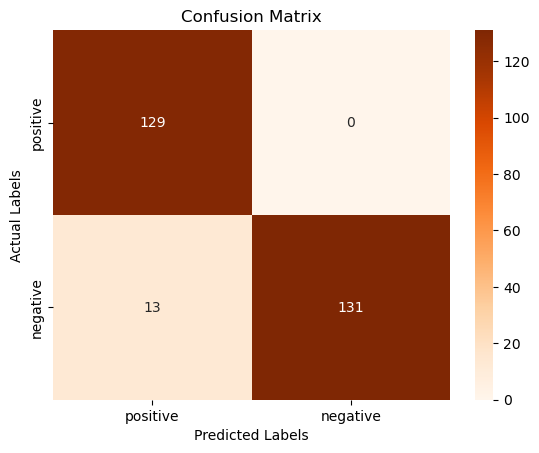

In [53]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

labels = ['positive', 'negative']
print("CNN 1D Accuracy: %.2f%%" % (accuracy_score(y_test, predictions)*100))
print("CNN 1D Precision: %.2f%%" % (precision_score(y_test, predictions, average="macro")*100))
print("CNN 1D Recall: %.2f%%" % (recall_score(y_test,predictions, average="macro")*100))
print("CNN 1D f1_score: %.2f%%" % (f1_score(y_test, predictions, average="macro")*100))
print(classification_report(y_test, predictions))

cm_df=pd.DataFrame(confusion_matrix(y_test, predictions), index=labels, columns=labels)

sns.heatmap(cm_df, annot=True, fmt="g", cmap='Oranges')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# 2.GPT

In [64]:
X_train

1150    according arokarhu purchases scanned cash regi...
547     finland insurance company pohjola finnish moto...
1766    purpose action ensure company cost effectivene...
284     would increase estimated sales 117 million las...
1936    aim ensure vacon good shape capital expenditur...
                              ...                        
4844    net sales paper segment decreased eur 2216 mn ...
2126    middle east north africa tecnotree grown consi...
2182    reuse back pet bottles also steadily increased...
4086    ebit excluding nonrecurring items estimated in...
1482    intel atom processor tremendous success market...
Name: sentence, Length: 2453, dtype: object

In [ ]:
pip install accelerate -U

In [ ]:
# example
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, Trainer, TrainingArguments

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=2)  # Assuming binary classification

# Convert DataFrame column to list of strings
sentences = X_train.tolist()

# Add a new padding token
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# Tokenize your dataset
train_encodings = tokenizer(sentences, truncation=True, padding=True, max_length=512)
# Convert labels to a format compatible with GPT2ForSequenceClassification

# Define TrainingArguments and use Trainer to fine-tune the model
training_args = TrainingArguments(
    output_dir='./results',          
    num_train_epochs=3,              
    per_device_train_batch_size=4,  
    per_device_eval_batch_size=8,   
    warmup_steps=500,                
    weight_decay=0.01,               
    logging_dir='./logs',            
)

trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=X_train,         
)

trainer.train()

In [ ]:
# example
import openai

openai.api_key = 'your-api-key'

response = openai.Completion.create(
  engine="text-davinci-002",  # or another available engine
  prompt="This is a tweet sentiment classifier\n\nTweet: \"I love sunny days!\"\nSentiment:",
  temperature=0.5,
  max_tokens=60,
  top_p=1.0,
  frequency_penalty=0.0,
  presence_penalty=0.0
)

print(response.choices[0].text.strip())

### LLM tagging

In [70]:
from langchain.chains import create_tagging_chain, create_tagging_chain_pydantic
from langchain_openai import ChatOpenAI

In [72]:
# Schema
schema = {
    "properties": {
        "sentiment": {
            "type": "integer",
            "enum": [1,0],
            "description": "describes the sentiment of the sentence, if the sentiment is positive, the value is 1, if it's negative, th evalue is 0",
        }
}

# LLM
llm = ChatOpenAI(temperature=0, model="gpt-3.5-turbo-0613", openai_api_key="")
chain = create_tagging_chain(schema, llm)

In [ ]:
# Assuming you have a test dataset `test_data` with sentences and sentiment labels

# Initialize an empty list to store predicted sentiment labels
predicted_sentiments = []

# Iterate over the test data and generate predictions
for sentence in X_test:
    # Generate prediction using langchain model
    prediction = chain(sentence)
    # Extract the predicted sentiment label from the prediction
#     predicted_sentiment = prediction['sentiment']
    # Append the predicted sentiment label to the list
    predicted_sentiments.append(prediction)

return predicted_sentiments

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_sentiments)
print("Accuracy:", accuracy)

In [ ]:
labels = ['positive', 'negative']
print("CNN 1D Accuracy: %.2f%%" % (accuracy_score(y_test, predictions)*100))
print("CNN 1D Precision: %.2f%%" % (precision_score(y_test, predictions, average="macro")*100))
print("CNN 1D Recall: %.2f%%" % (recall_score(y_test,predictions, average="macro")*100))
print("CNN 1D f1_score: %.2f%%" % (f1_score(y_test, predictions, average="macro")*100))
print(classification_report(y_test, predictions))

cm_df=pd.DataFrame(confusion_matrix(y_test, predictions), index=labels, columns=labels)

sns.heatmap(cm_df, annot=True, fmt="g", cmap='Oranges')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()